# Лабораторная работа 1

In [1]:
import math
import time
import numpy as np
from scipy.stats import kstest
from scipy.stats import chisquare
from scipy.stats import gamma as gm
from scipy.stats import chi2
from scipy.stats import t
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
mplstyle.use(['dark_background'])

## Генерация БСВ
Мультипликативный конгруэнтный метод

In [2]:
class BSV:
    def __init__(self):
        self.m = 524288
        self.k = 401321
        self.count = 0
        self.prev_a = np.mod(int(time.time() * 1000000), self.m) 
    
    def next(self):
        self.prev_a = np.mod(self.k * self.prev_a, self.m)
        self.count += 1
        return self.prev_a / self.m

In [3]:
def bsv(n):
    bsv = BSV()
    return [bsv.next() for i in range(n)]

In [4]:
seq = bsv(10000)
m, v = np.mean(seq), np.var(seq)
print('M[X] = {} ({}), D[X] = {} ({})'.format(m, 1./2, v, 1./12))

M[X] = 0.5010379974365234 (0.5), D[X] = 0.08461861675799326 (0.08333333333333333)


In [6]:
def mean_cinterval(seq, confidence=0.95):
    n, mean, s = len(seq), np.mean(seq), np.power(np.var(seq), 1./2)
    h = s * np.abs(t.isf(confidence, n-1)) / np.power(n-1, 1./2)
    return (mean-h, mean+h)

def var_cinterval(seq, confidence=0.95):
    n, var = len(seq), np.var(seq)
    return (n*var/chi2.isf((1-confidence)/2, n-1), n*var/chi2.isf((1+confidence)/2, n-1))

## Тестирование равномерности

In [7]:
for i in range(1, 5):
    n = 10 ** i
    seq = bsv(n)
    m, v = np.mean(seq), np.var(seq)
    dm, dv = np.abs(1./2 - m), np.abs(1./12 - v)
    print('n = {}: M[X] = {}(d = {}), D[X] = {}(d = {})'.format(n, m, dm, v, dv))

n = 10: M[X] = 0.4775135040283203(d = 0.022486495971679676), D[X] = 0.0657570325792767(d = 0.017576300754056626)
n = 100: M[X] = 0.4568427276611328(d = 0.04315727233886718), D[X] = 0.07420708426730707(d = 0.009126249066026257)
n = 1000: M[X] = 0.5157493286132813(d = 0.015749328613281266), D[X] = 0.08512898612862825(d = 0.001795652795294922)
n = 10000: M[X] = 0.49829822692871095(d = 0.0017017730712890478), D[X] = 0.08278183821227267(d = 0.0005514951210606606)


## Генерация НСВ с гамма-распределением

In [8]:
def gamma_vector(delta, a1, a2):
    u0 = 1./(1 + delta/np.e)
    if a1 <= u0:
        xi = np.power(a1/u0, 1./delta)
        eta = a2 * np.power(xi, delta - 1)
    else:
        xi = 1 - np.log((a1 - u0)/(1 - u0))
        eta = a2 * np.exp(-xi)
    return xi, eta

def next_gamma_z(delta, bsv):
    while True:
        a1 = bsv.next()
        a2 = bsv.next()
        xi, eta = gamma_vector(delta, a1, a2)
        if eta <= np.power(xi, delta - 1) * np.exp(-xi):
            return xi

def next_gamma_e(vz, bsv):
    return sum([np.log(bsv.next()) for i in range(1, vz+1)])

def next_gamma(k, theta, bsv):
    vz = int(k)
    delta = k - vz
    xi_z = 0 if delta == 0 else next_gamma_z(delta, bsv)
    return theta * (xi_z - next_gamma_e(vz, bsv))

def gamma(n, k, theta):
    bsv = BSV()
    return [next_gamma(k, theta, bsv) for i in range(n)]

def hist_bins(n):
    if n <= 100:
        return int(np.power(n, 1./2))
    else:
        return int(3.4 * np.log10(n))

M[X]: 11.399999999999999, 10.995676017375844
D[X]: 113.99999999999999, 106.32862140730545
mean confident interval: (10.458554537758843, 11.532797496992846)
var confident interval: (97.68478152840801, 116.42232035766669)
chi2: Power_divergenceResult(statistic=0.018754655875350766, pvalue=0.9999998635315097)


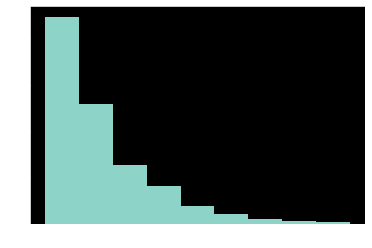

In [9]:
k = 1.14
th = 10
n = 1000
seq = gamma(n, k, th)
sbins = np.arange(0, max(seq), max(seq)/hist_bins(n))
hist, _ = np.histogram(seq, bins=sbins)
hist = hist/n
plt.hist(_[:-1], _, weights=hist)
seq2 = gm.rvs(k, scale=th, size=n)
hist2, _ = np.histogram(seq2, bins=sbins)
hist2 = hist2/n
print('M[X]: {}, {}'.format(k*th, np.mean(seq)))
print('D[X]: {}, {}'.format(k*(th**2), np.var(seq)))
print('mean confident interval:', mean_cinterval(seq))
print('var confident interval:', var_cinterval(seq))
print('chi2:', chisquare(f_obs=hist, f_exp=hist2, ddof=2))
plt.show()

## Генерация ДСВ
Универсальный метод

In [10]:
def take_c(c, q, a):
    i, ln = 0, len(q)
    while i < ln-1:
        if a < q[i]:
            break
        i += 1
    return c[i]

def discrete(c, p, n=100):
    bsv = BSV()
    q = [p[0]]
    for i in range(1, len(p)):
        q.append(p[i] + q[-1])
    return np.array([take_c(c, q, bsv.next()) for i in range(n)])

M[X]: 2.5999999999999996, 2.635
D[X]: 0.44000000000000006, 0.4057750000000001
mean confident interval: (2.601818954053095, 2.6681810459469046)
var confident interval: (0.37278807624949034, 0.4442949265952435)
chi2: Power_divergenceResult(statistic=0.002097210944725948, pvalue=0.998951944122236)


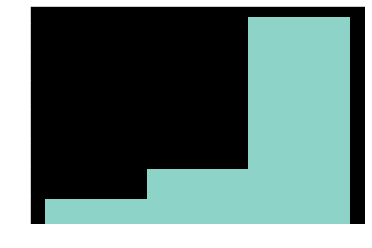

In [11]:
c = [1, 2, 3]
count = len(c)
p = [0.1, 0.2, 0.7]
seq = discrete(c, p, 1000)
dbins = [0]+[x+0.001 for x in c]
hist, _ = np.histogram(seq, bins=dbins, density=True)
plt.hist(_[:-1], _, weights=hist)
seq2 = np.random.choice(c, 1000, p=p)
hist2, _ = np.histogram(seq2, bins=dbins, density=True)
m = sum([c[i]*p[i] for i in range(count)])
v = sum([(c[i] - m)**2 * p[i] for i in range(count)])
print('M[X]: {}, {}'.format(m, np.mean(seq)))
print('D[X]: {}, {}'.format(v, np.var(seq)))
print('mean confident interval:', mean_cinterval(seq))
print('var confident interval:', var_cinterval(seq))
print('chi2:', chisquare(f_obs=hist, f_exp=hist2, ddof=0))
plt.show()

In [12]:
def check_xy(x, y, i, j, ixy, bins_x, bins_y):
    c1 = x[ixy] >= bins_x[i] and x[ixy] < bins_x[i+1]
    c2 = y[ixy] >= bins_y[j] and y[ixy] < bins_y[j+1]
    return c1 and c2

def xy_hist(x, y, bins_x, bins_y):
    x.sort()
    y.sort()
    hist_x, _ = np.histogram(x, bins=bins_x)
    hist_y, _ = np.histogram(y, bins=bins_y)
    n, k, m = len(x), len(hist_x), len(hist_y)
    v = np.zeros((k, m))
    for i in range(k):
        for j in range(m):
            v[i][j] = len([0 for ii in range(n) if check_xy(x, y, i, j, ii, bins_x, bins_y)])
    st = 0
    for i in range(k):
        for j in range(m):
            st += ((v[i][j] - hist_x[i] * hist_y[j] / n)**2)/(hist_x[i] * hist_y[j])
    chi = chi2.isf(0.95, (k - 1)*(m - 1))
    return st, chi

In [14]:
n = 1000
seq1, seq2 = bsv(n), bsv(n)
bins1, bins2 = np.arange(0, max(seq1), max(seq1)/hist_bins(n)), np.arange(0, max(seq2), max(seq2)/hist_bins(n))
hist1, _b1 = np.histogram(seq1, bins=bins1)
hist2, _b2 = np.histogram(seq2, bins=bins2)
print(xy_hist(seq1, seq2, bins1, bins2))

(7.299509952322644, 46.59490522481397)
